In [1]:
train_dir = "/kaggle/input/juivcdv1-indian-vehicle-classification/JUVC/data/train"
val_dir = "/kaggle/input/juivcdv1-indian-vehicle-classification/JUVC/data/train"
test_dir = "/kaggle/input/juivcdv1-indian-vehicle-classification/JUVC/data/test"

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, InputLayer, BatchNormalization, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

import gc
import copy

In [3]:
img_height, img_width = 220, 220
batch_size = 32
num_classes = 12
num_snapshots = 3
num_epochs_per_snapshot = 25
final_epoch = 20

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
                                   width_shift_range=0.2,horizontal_flip=True,height_shift_range=0.2) 


val_datagen = ImageDataGenerator( rescale=1.0 / 255 )

test_datagen = ImageDataGenerator( rescale=1.0 / 255 )

train_generator = train_datagen.flow_from_directory( train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='categorical',
                                                    shuffle=True)

val_generator = test_datagen.flow_from_directory( val_dir,                                              
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size, class_mode='categorical',
                                                  shuffle=False )

test_generator = test_datagen.flow_from_directory( test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size, class_mode='categorical',
                                                  shuffle=False )

Found 4357 images belonging to 12 classes.
Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras.layers import *

In [6]:
num_heads = 5
reduction_ratio = 8
dropout_rate = 0.02
l2_reg = 0.01


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Conv2D, Multiply, SeparableConv2D, LayerNormalization, Dropout, BatchNormalization

def multihead_attention(input_tensor, num_heads=5):
  # Split input into multiple heads
    input_shape = input_tensor.shape
    depth = input_shape[-1]
    # Adjust depth to ensure it is evenly divisible by num_heads
    new_depth = depth + (num_heads - (depth % num_heads))

    # Modify input tensor depth if necessary
    if new_depth != depth:
        input_tensor = tf.keras.layers.Conv2D(new_depth, kernel_size=(1, 1))(input_tensor)

    # Calculate depth per head
    depth_per_head = new_depth // num_heads

    # Channel attention
    channel_avg = layers.GlobalAveragePooling2D()(input_tensor)
    channel_max = layers.Lambda(lambda x: tf.reduce_max(x, axis=[1, 2]))(input_tensor)
    channel_concat = layers.Concatenate(axis=1)([channel_avg, channel_max])

    channel_dense1 = layers.Dense(units=depth // num_heads, activation='sigmoid')(channel_concat)
    channel_attention = layers.Reshape((1, 1, depth // num_heads))(channel_dense1)

    channel_attention = layers.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]))(channel_attention)

    # Spatial attention
    spatial_avg = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    spatial_max = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)

    spatial_concat = layers.Concatenate(axis=-1)([spatial_avg, spatial_max])
    spatial_conv = layers.Conv2D(filters=num_heads, kernel_size=3, padding='same', activation='sigmoid')(spatial_concat)

    spatial_attention = layers.Lambda(lambda x: tf.split(x, num_heads, axis=-1))(spatial_conv)

    attention = layers.Add()([channel_attention] + spatial_attention)
    attention = layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(attention)

    # Apply attention
    attention_map = layers.Concatenate()([input_tensor, attention])
    attention_map = BatchNormalization()(attention_map)
    attention_map = Dropout(0.02)(attention_map)

    # Feature maps
    feature_maps = layers.Concatenate()([input_tensor,  attention_map]) # Testing Phase

    return feature_maps, attention_map

def cbam_block(input_tensor):
    feature_maps, attention_map = multihead_attention(input_tensor)
    return feature_maps, attention_map


In [8]:
from tensorflow.keras.layers import Lambda, DepthwiseConv2D, BatchNormalization, Dropout, Reshape, UpSampling2D, Multiply

In [9]:
from tensorflow.keras.applications import Xception
def create_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    x = SeparableConv2D(512, kernel_size=(3, 3), activation='sigmoid',
                        depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                        pointwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                        padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    # CBAM block
    feature_maps, attention_map = cbam_block(x)
    feature_maps = BatchNormalization()(feature_maps)
    x = Dropout(0.02)(feature_maps)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)

    preds = Dense(units=num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=preds)
    
    for layer in model.layers:
        layer.trainable = True
    
    return model


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class CosineAnnealingScheduler(Callback):
    def __init__(self, initial_lr, T_max, eta_min=0, verbose=0):
        super().__init__()
        self.initial_lr = initial_lr
        self.T_max = T_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.calculate_lr(epoch)
        if self.verbose > 0:
            print(f'\nEpoch {epoch+1}: Learning rate is {lr:.6f}.')
        self.model.optimizer.learning_rate = lr  # Directly set the learning rate

    def calculate_lr(self, epoch):
        cos_inner = np.pi * (epoch % self.T_max)
        cos_inner /= self.T_max
        cos_out = np.cos(cos_inner) + 1
        return self.eta_min + ((self.initial_lr - self.eta_min) * cos_out) / 2


initial_learning_rate = 0.0001  
max_epochs = num_epochs_per_snapshot
max_epochs2 = final_epoch
min_learning_rate = 0.000001 

scheduler = CosineAnnealingScheduler(initial_learning_rate, T_max=max_epochs, 
                                     eta_min=min_learning_rate, verbose=1)

In [11]:
# Custom Dominant Strategy Loss function
class DominantStrategyLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_reg=0.1):
        super(DominantStrategyLoss, self).__init__()
        self.lambda_reg = lambda_reg

    def call(self, y_true, y_pred):
        # Compute per-class cross-entropy loss
        per_class_losses = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Compute dominant strategies (e.g., using class accuracy)
        dominant_strategies = y_true  # Placeholder implementation: assuming the dominant strategy is the one-hot encoded label

        # Compute Kullback-Leibler divergence between predicted and dominant strategies
        kl_divergences = tf.keras.losses.KLDivergence()(y_pred, dominant_strategies)

        # Compute total loss
        total_loss = tf.reduce_mean(per_class_losses) + self.lambda_reg * tf.reduce_mean(kl_divergences)

        return total_loss

loss_function = DominantStrategyLoss(lambda_reg=0.1)

In [12]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall, MeanSquaredError, Accuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC, Precision, Recall, F1Score
from numpy import average

def snapshot_ensemble(train_generator, val_generator, num_snapshots, num_epochs_per_snapshot):
    
    ensemble_models = []
    snapshot_weights = []
    validation_accuracies = [] 
    test_accuracies = []  # To store test accuracy of each snapshot
    
    best_test_accuracy = 0
    best_snapshot_index = -1
    
    for snapshot in range(num_snapshots):
        print(f"Training snapshot {snapshot + 1}/{num_snapshots}")
        
        model = create_model()
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', 
                      metrics=['accuracy', 'mse', Precision(), Recall(), F1Score(), AUC(curve='ROC')])
        
        scheduler = CosineAnnealingScheduler(initial_learning_rate, T_max=max_epochs, 
                                             eta_min=min_learning_rate, verbose=2)
        
        history = model.fit(train_generator, epochs=num_epochs_per_snapshot, validation_data=val_generator, 
                            callbacks=[scheduler], verbose=1)
        
        evaluation = model.evaluate(test_generator)
        print("Test Loss:", evaluation[0])
        print("Test Accuracy:", evaluation[1])
        
        validation_accuracies.append(max(history.history['val_accuracy']))
        
        test_accuracies.append(evaluation[1])  # Assuming the second returned value is accuracy
        
        if evaluation[1] > best_test_accuracy:
            best_test_accuracy = evaluation[1]
            best_snapshot_index = snapshot
        
        snapshot_weights.append(model.get_weights())
        ensemble_models.append(model)
    
    # Adjusting weights based on validation accuracies and giving bonus to the best test accuracy
    adjusted_weights = np.array(validation_accuracies)
    adjusted_weights /= np.sum(adjusted_weights)  # Normalize
    adjusted_weights[best_snapshot_index] += 0.1  # Adding bonus weight, ensure it doesn't exceed 1 after normalization
    adjusted_weights /= np.sum(adjusted_weights)  # Re-normalize after bonus
    
    # Use adjusted weights for calculating the weighted average of model weights
    weighted_avg_weights = []
    for layer_index in range(len(snapshot_weights[0])):
        layer_weights = np.array([snapshot_weights[i][layer_index] for i in range(num_snapshots)])
        weighted_layer = np.average(layer_weights, axis=0, weights=adjusted_weights)
        weighted_avg_weights.append(weighted_layer)

    return ensemble_models, weighted_avg_weights


In [13]:
ensemble_models, weighted_avg_weights = snapshot_ensemble(train_generator, val_generator, 
                                                        num_snapshots, num_epochs_per_snapshot)

Training snapshot 1/3
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Epoch 1: Learning rate is 0.000100.
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724774305.626688     121 service.cc:145] XLA service 0x7c9d00003660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724774305.626765     121 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724774345.693079     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/137 ━━━━━━━━━━━━━━━━━━━━ 18s 912ms/step - accuracy: 0.7443 - auc: 0.9453 - f1_score: 0.5929 - loss: 10.7036 - mse: 0.0275 - precision: 0.8701 - recall: 0.6936

I0000 00:00:1724774451.643309     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 440 bytes spill stores, 440 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 16 bytes spill stores, 16 bytes spill loads



137/137 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.7638 - auc: 0.9519 - f1_score: 0.6170 - loss: 10.5532 - mse: 0.0256 - precision: 0.8790 - recall: 0.7170 - val_accuracy: 0.1306 - val_auc: 0.6078 - val_f1_score: 0.0397 - val_loss: 10.6608 - val_mse: 0.0772 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 2: Learning rate is 0.000100.
Epoch 2/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 90s 637ms/step - accuracy: 0.9707 - auc: 0.9994 - f1_score: 0.9236 - loss: 7.6304 - mse: 0.0037 - precision: 0.9737 - recall: 0.9638 - val_accuracy: 0.4524 - val_auc: 0.8899 - val_f1_score: 0.3994 - val_loss: 7.7245 - val_mse: 0.0577 - val_precision: 1.0000 - val_recall: 0.0957

Epoch 3: Learning rate is 0.000098.
Epoch 3/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 91s 640ms/step - accuracy: 0.9818 - auc: 0.9998 - f1_score: 0.9616 - loss: 5.6899 - mse: 0.0022 - precision: 0.9836 - recall: 0.9809 - val_accuracy: 0.9888 - val_auc: 0.9998 - val_f1_score: 0.9834 - val_loss: 4.9320 - val_mse: 0.0134 - val_precision: 

In [15]:
final_model = create_model() 

checkpoint = ModelCheckpoint('SSE_Dnet121_juivcd.weights.h5', monitor='val_accuracy', 
                             save_best_only = True, save_weights_only = True, mode ='max', verbose = 1)

scheduler = CosineAnnealingScheduler(initial_learning_rate, T_max=max_epochs2, 
                                     eta_min=min_learning_rate, verbose=1)
        
final_model.compile(optimizer=Adam(learning_rate = 0.0001), loss=loss_function, 
                      metrics=['accuracy', 'mse', Precision(), Recall(), F1Score(), AUC(curve='ROC')])  
        
final_model.set_weights(weighted_avg_weights)

history = final_model.fit(train_generator, epochs=final_epoch, validation_data=val_generator, 
                  callbacks=[checkpoint, scheduler], verbose=1)

evaluation = final_model.evaluate(test_generator)

print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])


Epoch 1: Learning rate is 0.000100.
Epoch 1/20
115/137 ━━━━━━━━━━━━━━━━━━━━ 14s 653ms/step - accuracy: 0.9947 - auc_4: 1.0000 - f1_score: 0.9729 - loss: 0.1496 - mse: 0.0011 - precision_4: 0.9961 - recall_4: 0.9888

I0000 00:00:1724781755.018102     121 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 440 bytes spill stores, 440 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 16 bytes spill stores, 16 bytes spill loads



137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9947 - auc_4: 1.0000 - f1_score: 0.9745 - loss: 0.1455 - mse: 0.0010 - precision_4: 0.9960 - recall_4: 0.9894
Epoch 1: val_accuracy improved from -inf to 0.99954, saving model to SSE_Dnet121_juivcd.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 842ms/step - accuracy: 0.9947 - auc_4: 1.0000 - f1_score: 0.9746 - loss: 0.1454 - mse: 0.0010 - precision_4: 0.9960 - recall_4: 0.9894 - val_accuracy: 0.9995 - val_auc_4: 1.0000 - val_f1_score: 0.9993 - val_loss: 0.1283 - val_mse: 3.0990e-04 - val_precision_4: 0.9998 - val_recall_4: 0.9984

Epoch 2: Learning rate is 0.000099.
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9933 - auc_4: 0.9996 - f1_score: 0.9815 - loss: 0.1124 - mse: 8.1917e-04 - precision_4: 0.9951 - recall_4: 0.9927
Epoch 2: val_accuracy did not improve from 0.99954
137/137 ━━━━━━━━━━━━━━━━━━━━ 87s 614ms/step - accuracy: 0.9933 - auc_4: 0.9996 - f1_score: 0.9816 - loss: 0.1125 - mse: 8.2155e-04 - precis

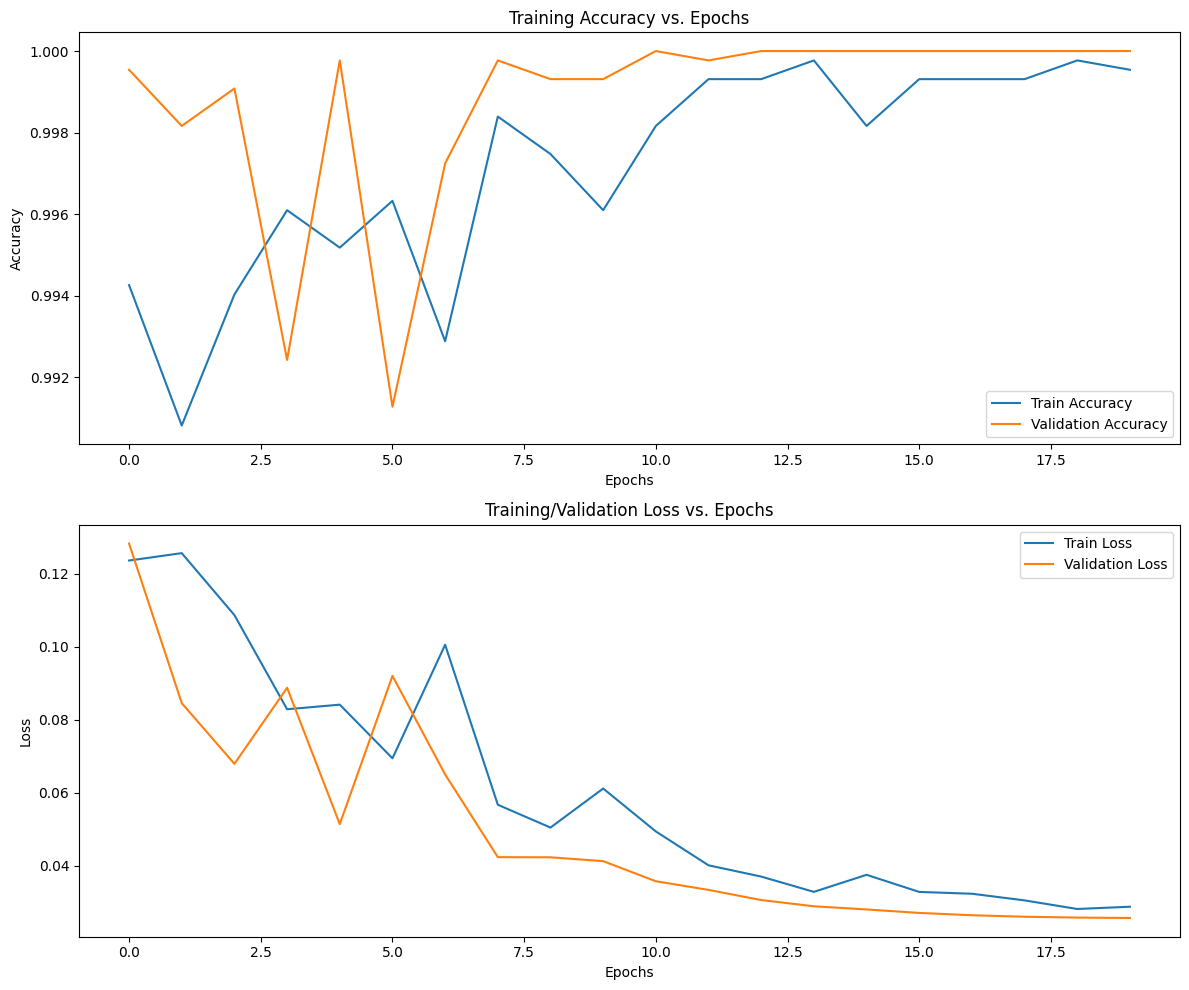

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, label='Train Accuracy')
ax[0].plot(val_accuracy, label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, label='Train Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [19]:
import IPython
IPython.display.FileLink('SSE_Dnet121_juivcd.weights.h5')

/kaggle/working/SSE_Dnet121_juivcd.weights.h5

In [20]:
final_model.load_weights("/kaggle/working/SSE_Dnet121_juivcd.weights.h5")

In [21]:
evaluation = final_model.evaluate(test_generator)

print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9486 - auc_4: 0.9887 - f1_score: 0.5236 - loss: 0.3923 - mse: 0.0074 - precision_4: 0.9515 - recall_4: 0.9476
Test Loss: 0.2674383521080017
Test Accuracy: 0.9644768834114075


In [22]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

In [23]:
# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = final_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step


65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step


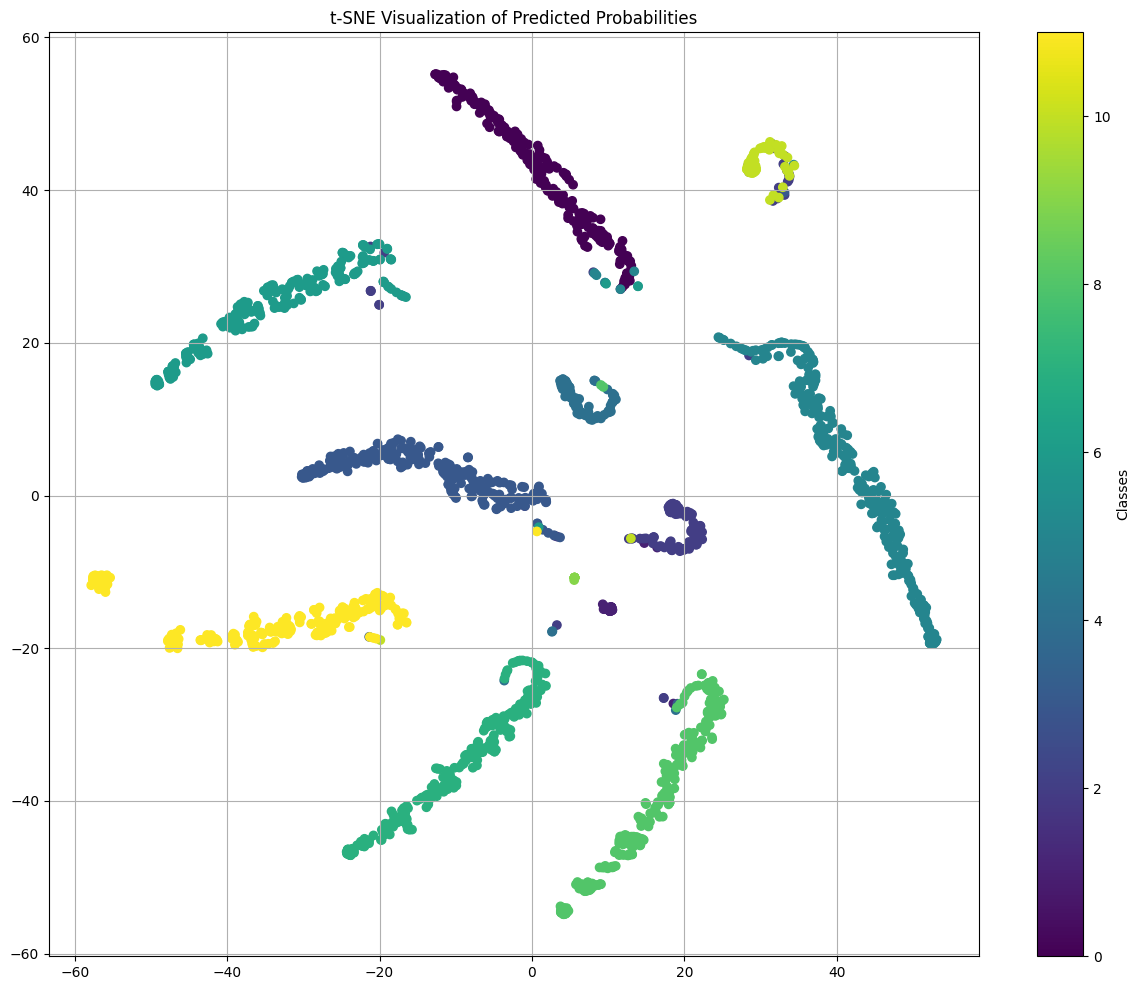

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have predicted probabilities and true labels for multi-class classification
true_labels = test_generator.classes
predictions = final_model.predict(test_generator)

# Perform t-SNE dimensionality reduction on predicted probabilities
tsne = TSNE(n_components=2, random_state=42)
predicted_tsne = tsne.fit_transform(predictions)

# Plot t-SNE visualization
plt.figure(figsize=(15, 12))
plt.scatter(predicted_tsne[:, 0], predicted_tsne[:, 1], c=true_labels, cmap='viridis')
plt.colorbar(label='Classes')
plt.title('t-SNE Visualization of Predicted Probabilities')
plt.grid(True)
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step


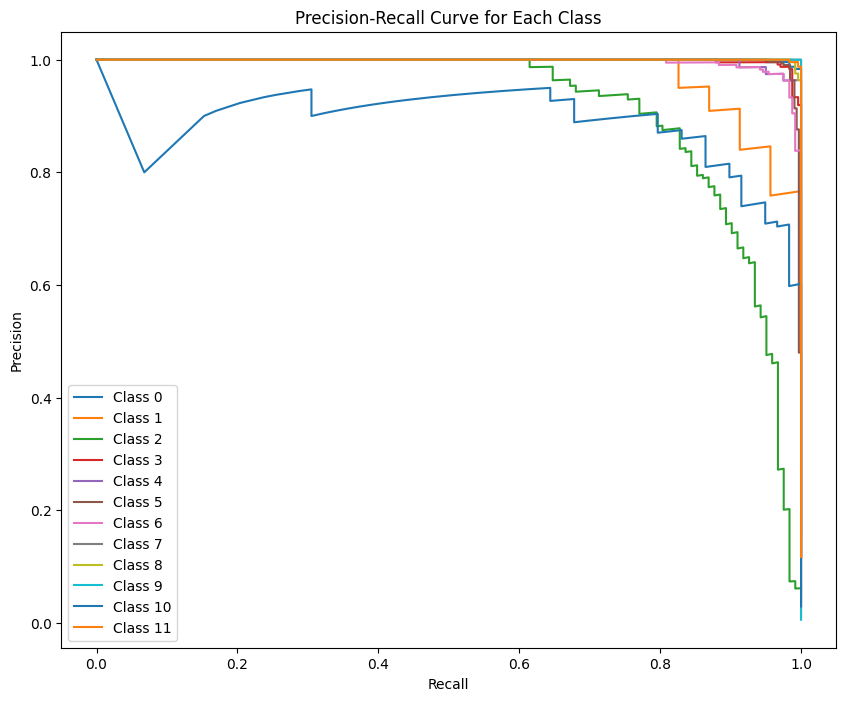

In [25]:
from sklearn.metrics import precision_recall_curve

# Assuming you have true labels and predicted probabilities for each class
true_labels = test_generator.classes  # Actual labels
predictions = final_model.predict(test_generator)  # Predicted probabilities for each class

# For each class, calculate precision and recall
precision = dict()
recall = dict()
for i in range(num_classes):  # Replace 'num_classes' with the number of classes (196)
    precision[i], recall[i], _ = precision_recall_curve(true_labels == i, predictions[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step


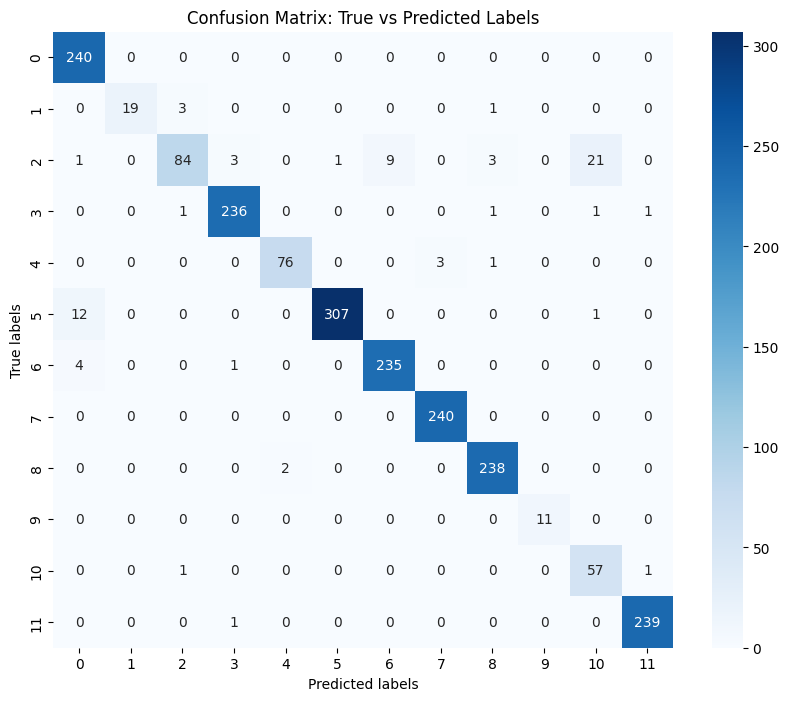

              precision    recall  f1-score      support
0              0.933852  1.000000  0.965795   240.000000
1              1.000000  0.826087  0.904762    23.000000
2              0.943820  0.688525  0.796209   122.000000
3              0.979253  0.983333  0.981289   240.000000
4              0.974359  0.950000  0.962025    80.000000
5              0.996753  0.959375  0.977707   320.000000
6              0.963115  0.979167  0.971074   240.000000
7              0.987654  1.000000  0.993789   240.000000
8              0.975410  0.991667  0.983471   240.000000
9              1.000000  1.000000  1.000000    11.000000
10             0.712500  0.966102  0.820144    59.000000
11             0.991701  0.995833  0.993763   240.000000
accuracy       0.964477  0.964477  0.964477     0.964477
macro avg      0.954868  0.945007  0.945836  2055.000000
weighted avg   0.967168  0.964477  0.963780  2055.000000


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming you have true labels and predicted labels for 196 classes
true_labels = test_generator.classes  # Actual labels
predictions = final_model.predict(test_generator)  # Predicted probabilities or class labels

# Convert predicted probabilities to class labels if necessary
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate aggregated metrics
classification_rep = classification_report(true_labels, predicted_labels, output_dict=True)
metrics_df = pd.DataFrame(classification_rep).transpose()

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: True vs Predicted Labels')
plt.show()

# Display aggregated metrics
print(metrics_df)

In [27]:
# Extracting metrics using classification_report
metrics = classification_report(true_labels, predicted_labels, output_dict=True)

In [28]:
# Calculate average metrics for all classes
avg_precision = metrics['macro avg']['precision']
avg_recall = metrics['macro avg']['recall']
avg_f1_score = metrics['macro avg']['f1-score']

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-Score:", avg_f1_score)

Average Precision: 0.9548681544922671
Average Recall: 0.9450073534667439
Average F1-Score: 0.9458356384474732


In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [30]:
final_model.save('finalmodel_cmanxception.weights.h5.keras')

In [31]:
final_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 220, 220,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 109, 109,  │        864 │ input_layer_4[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 109, 109,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 109, 109,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 107, 107,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 107, 107,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 107, 107,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 107, 107,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 107, 107,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 107, 107,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 107, 107,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 107, 107,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 54, 54,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 54, 54,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        512 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (None, 54, 54,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 54, 54,    │          0 │ add_52[0][0]    

 Total params: 66,867,315 (255.08 MB)

 Trainable params: 22,267,503 (84.94 MB)

 Non-trainable params: 64,804 (253.14 KB)

 Optimizer params: 44,535,008 (169.89 MB)

In [ ]:
#model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_24"

img_path = '/kaggle/input/juivcdv1-indian-vehicle-classification/JUVC/data/test/0_Car/images/0 (1).png'

display(Image(img_path))


# def get_img_array(img_path, size):
#     # `img` is a PIL image of size 299x299
#     img = keras.preprocessing.image.load_img(img_path, target_size=size)
#     # `array` is a float32 Numpy array of shape (299, 299, 3)
#     array = keras.preprocessing.image.img_to_array(img)
#     # We add a dimension to transform our array into a "batch"
#     # of size (1, 299, 299, 3)
#     array = np.expand_dims(array, axis=0)
#     return array

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, final_model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [final_model.inputs], [final_model.get_layer(last_conv_layer_name).output, final_model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Prepare image
img_array = get_img_array(img_path, size=img_size)

# Make model
#model = model_builder(weights="imagenet")


# Remove last layer's softmax
final_model.layers[-1].activation = None

# Print what the top predicted class is
preds = final_model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)


In [ ]:
model.load_weights("/kaggle/input/cmanxcep/finalmodel_cmanxception.weights.h5.keras")

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def visualize_class_activation_map(model, img_path, output_path, layer_name, thr=None, verbose=True):
        original_img = Image.open(img_path).convert('RGB')
        original_img = original_img.resize((256, 256))
        img_arr = np.array(original_img)/255.
        width, height, _ = img_arr.shape
        cam_model = tf.keras.Model(model.input, model.get_layer(layer_name).output)
        cam = cam_model(np.array([img_arr])).numpy()[0]
        print(img_arr.shape)
        mask = np.mean(cam,axis=-1)
        mask = (mask - np.min(mask))/(np.max(mask) - np.min(mask))
        print(mask.shape)

#         if thr is None:
#             mask[mask<np.mean(mask)]=0
#             mask[mask>0]=1
#         else:
#             mask[mask<thr] = 0


        mask_width, mask_height = mask.shape
#       mask = GaussianBlurLayer(kernel_size=3, sigma=mask_width/28)(np.reshape(mask,(1,mask_width,mask_height,1)))[0].numpy()

      # mask_width, mask_height = mask.shape
        scaled_mask = tf.keras.layers.UpSampling2D(size=(width//mask_width, height//mask_height),interpolation="bilinear")(np.reshape(mask,(1,mask_width,mask_height,1)))[0].numpy()
        print(scaled_mask.shape)
        new_shape = (256, 256, 3)
        img_arr = img_arr[:new_shape[0], :new_shape[1]]
        attentive_img = ((img_arr*scaled_mask)*255).astype(int)

        return original_img, mask, scaled_mask, attentive_img



img_path = '/kaggle/input/newmiobdwithoutmulti/MIO-BD/test/Truck/images/17 (1).jpg'
output_path = '/content/007.png'
layer_name = 'conv2d_27'
original_img, mask, scaled_mask, attentive_img = visualize_class_activation_map(model, img_path, output_path, layer_name)
plt.imshow(scaled_mask)